In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import os

import pandas as pd
import numpy as np

from source.babilong.metrics import compare_answers, TASK_LABELS

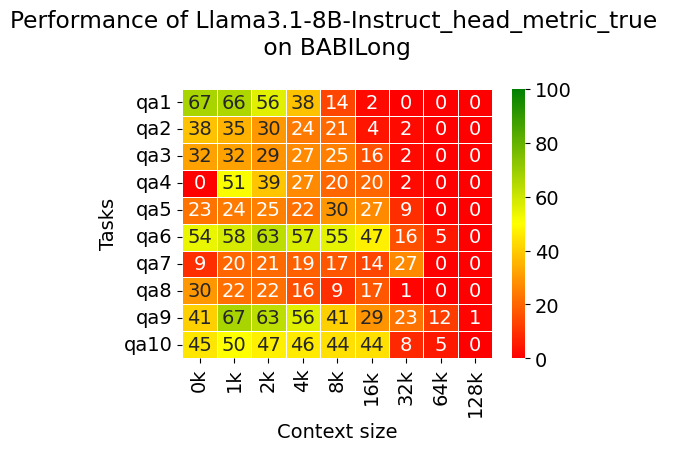

In [5]:
results_folder = './babilong_evals_ms_poe'
# model_name="Llama3-1"
model_name='Llama3.1-8B-Instruct_head_metric_true'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes_chat_template_yes'

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5', 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# tasks=['qa2','qa3','IF-qa2','IF-qa3']
lengths = [ 
    '0k','1k','2k',
    '4k','8k', '16k', '32k','64k','128k']

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    # ptask=task if "IF" not in task else task[3:]
    ptask=task.split("-")[-1]
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue

        df = pd.read_csv(fname)

        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output'],
                                                             row['question'], TASK_LABELS[ptask]
                                                             ), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()